![CC](https://i.creativecommons.org/l/by/3.0/88x31.png)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

# Contents
1. Introduction and structure of this repository  
2. Active flow control and the numerical setup  
    2.1 Active flow control and the general flow problem   
    2.2 Numerical setup  
3. Choosing parameters for a model-free (MF) training 
4. Performing a model-based (MB) training  
    4.1 Alternation between MF- and MB-episodes   
6. Final results for trainings with $Re = 100$  
8. Concluding remarks and potential issues

# 1. About this repository
This student thesis project aims to implement a model-based deep reinforcement learning (MB-DRL) algorithm for controlling the flow past a cylinder. The [drlfoam](https://github.com/OFDataCommittee/drlfoam) repository, which already provides a model-free version (MF-DRL) is herefore used as a starting point. A complete documentation of the work done in this project can be found in the [report](https://github.com/JanisGeise/robust_MB_DRL_for_flow_control) section of the *Readme* file, as well as the references used (it is also recommended to check out the [references](https://github.com/JanisGeise/robust_MB_DRL_for_flow_control) section at the bottom of the *Readme* file). The following notebook will give a brief summary of this report as well as an introduction about how to use this repository. In case contents of this notebook are not rendered correctly on Github, e.g. tables, please download and open this notebook locally using `jupyter-lab`. <br><br>
This repository contains three main directories:
- *mb_drl*:
    - The *mb_drl* directory contains all altered and added scripts of *drlfoam* in order to modify the MF-DRL algorithm towards an MB-version. These scripts can e.g. be downloaded and pasted into an existing (local) *drlfoam* version. Alternatively, a full MB-version of the *drlfoam* repository can be found [here](https://github.com/JanisGeise/drlfoam), which was forked from the [original drlfoam](https://github.com/OFDataCommittee/drlfoam) repository. <br><br>
- *test_env_models*:
    - **Note: these scripts are not up-to-date anymore, since they rely on an old implementation of the training routine**
    - The *test_env_models* directory provides scripts to test different ways of training- and testing environment models on the data generated by the (original) model-free DRL-algorithm. Prior using these scripts, a model-free training needs to be executed. Suggestions and advises on how to efficiently run a model-free training in drlfoam will be discussed in [section 3](#MF_training). Once the training data is generated, the *train_environment_model.py* script can be used to test the following configurations:
        - train one global environment model for all the training data without taking the episode number into account    
        - train one environment model for predicting $c_l$ and $p_i$ and another model for predicting $c_d$. These models are also trained on all the data available, despite considering the episode in which the data was generated
        - the same as the two aforementioned options, but this time the environment model (or models) are trained for each new episode. This means two consecutive episodes are taken for training the models(s), then these model(s) are used to predict the next episode
        - these four options are covering therefore all extrema, namely having either one model performing averagly over all episodes or highly specialized models performing well, but only for the specific episode they are trained for. In reality, one would now make a compromise between these two extrema, as it is done in the current implementation of the MB-DRL algorithm
        - an option for training the environment models with low-passed filtered trajectories for $c_d$, this has found to have only little effect on the results
        - options for fine-tuning the models, such as the number of time steps used as input, number of hidden layers, number of neurons and length of the trajectories
        - an option to predict the change of state rather than predicting the next state. This option produces complete unrealistic results for the trajectories of $c_l$ and $p_i$ and is therefore not recommended to use
        - the following table sums up the available options, which can be set in the *setup* dict of the *train_environment_model.py* script:  
        | option         |                     description                         | default / recommended value |  
        | ---            |                         ---                             |               ---           |  
        | load_path      | path to the training data generated with MF-DRL         | ../drlfoam/examples/test_training/ |  
        | path_to_probes | path to the location of the probe data, this normally should be the same for all cases | base/postProcessing/probes/0/ |  
        | model_dir      | directory where to run the script                       | test_env_models/ |  
        | episode_depending_model | either one global model for whole data set or a new model / new models is trained for each episode, based on the previous two episodes | False |  
        | two_env_models | if *True*: one model only for predicting $c_d$, another for $p_i$ and $c_l$; *False*: only one model for all three parameters                   | True  |  
        | print_temp     | print core temperatur of processor as info                                            | False |  
        | normalize      | if *True*: data will be normalized to interval of [1, 0] for training and predictions | True  |  
        | smooth_cd      | flag if $c_d$-trajectories should be filtered after loading (low-pass filter)         | False |  
        | predict_ds     | predict the change of state, not the next state itself                                | False |  
        | n_input_steps  | initial time steps as input for the environment models, is required to be $n_t \gt 1$        | 30 |  
        | len_trajectory | trajectory length for training the environment model, this option can be set independently of the trajectory length used in MF-DRL for creating the data. <br>The only prerequisite is, that *len_trajectory* $\%$ *length_trajectory(MF-DRL)* $== 0$                              | 200 |  
        | ratio          | splitting ratio for train-, validation and test data. For episode-wise models, the test data ratio needs to be set to zero since the each next episode is used as test data                                                                                                | (0.65, 0.3, 0.05) <br> (0.65, 0.35, 0.0)|  
        | epochs         | number of epochs to run for the environment model, if *two_env_models* then this refers to the model for $c_l$ and $p_i$        | 10 000 |  
        | n_neurons      | number of neurons per layer for the environment model, if *two_env_models* then this refers to the model for $c_l$ and $p_i$    | 50 |
        | n_layers       | number of hidden layers for the environment model, if *two_env_models* then this refers to the model for $c_l$ and $p_i$        | 3 |  
        | n_neurons_cd   | number of neurons per layer for the environment model for cd (if option *two_env_models* is set to *True*) | 50 |  
        | n_layers_cd    | number of hidden layers for the environment model for cd (if option *two_env_models* is set to *True*)     | 5 |  
        | epochs_cd      | number of epochs to run for the environment model for cd (if option *two_env_models* is set to *True*)     | 10 000 |  
        <br> 
    - Further, within this directory are scripts to post-process and visualize all results and data created, as well as conducting parameter studies with respect to the influence of the model architecture or number of time steps as input.<br> <br> 
- *scripts_py_plots*:
    - this directory provides scripts for post-processing all results generated over the course of the training (MB-DRL as well as MF-DRL)
    - various scripts for conducting parameter studies and visualizing data of these parameter studies, e.g. investigating the influence of the buffer size and trajectory length as shown in [section 3](#MF_training)

# 2. Active flow control and numerical setup
This section briefly discusses the general flow problem to solve and the numerical setup. As the name suggests, *drlfoam* uses the open-source CFD software [OpenFOAM](https://www.openfoam.com/), currently in the version *v2206*.

## 2.1 General flow problem
The *drlfoam* package aimes to control the flow past a cylinder using deep-reinforcement learning (DRL). The flow is unsteady and incompressible, the default Reynolds number is set to $Re = 100$. As depiced in the following figures, without flow control vortex shedding, formally known as Kármán vortex street, developes. During training, the agent tries to learn a control law by rotating the cylinder with the goal to minimize $c_l$ and $c_d$, hereby the angular velocity $\omega$ is bound by the interval $\omega \in [-5, 5]$. A comparison of the uncontrolled flow past a cylinder with the controlled flow, both at a Reynolds number of $Re = 100$, illustrates the effect of active flow control:
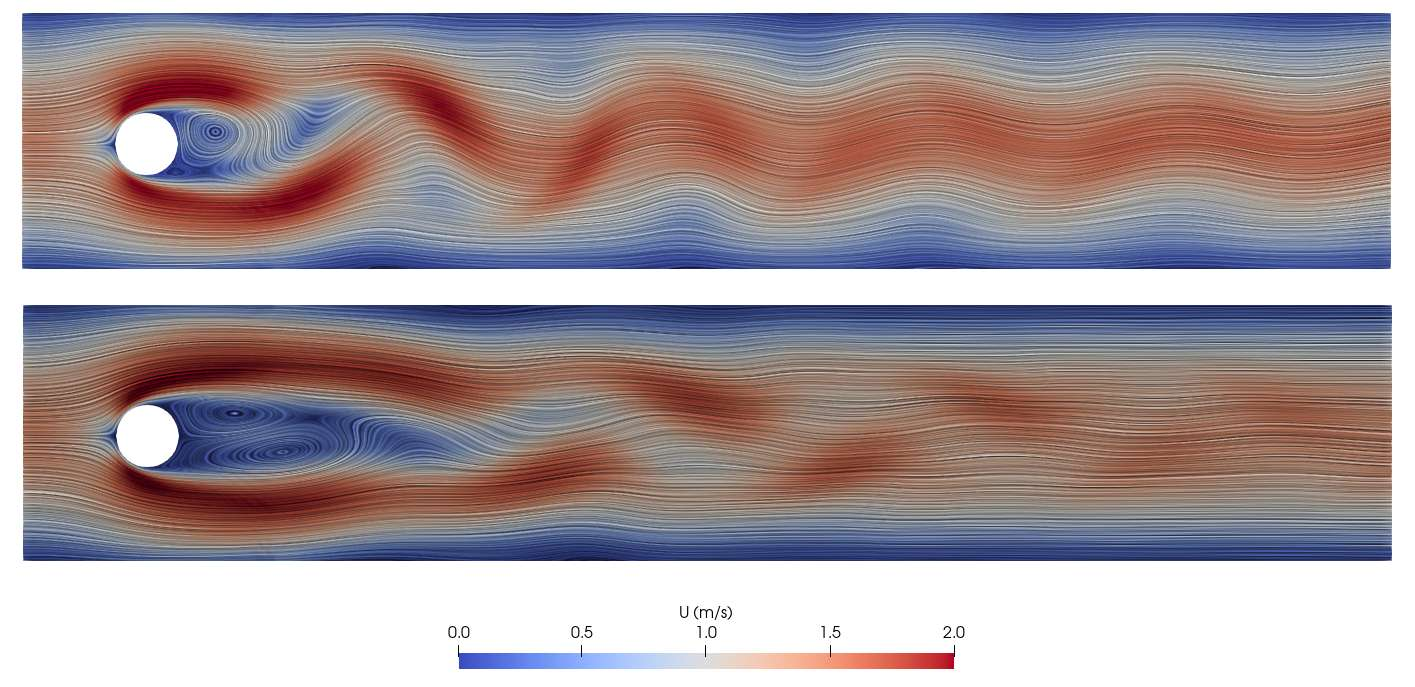

The upper figure shows the uncontrolled flow while in the lower figure active flow control was applied. Clearly it can be seen that by rotating the cylinder in an optimal way, the vortex shedding can be reduced significantly.

## 2.2 Numerical setup
The described flow problem is unsteady, therefore the transient, incompressible solver [pimpleFoam](https://www.openfoam.com/documentation/guides/latest/doc/guide-applications-solvers-incompressible-pimpleFoam.html) is used. The cylinder has a default diameter of  $d = 0.1m$, the free stream velocity is $U_{\infty} = 1 m/s$. During the simulation, $c_l$ and $c_d$ at the cylinder surface are written out as well as pressure values $p_i$ at defined positions within the flow field. In the default setup, the number of probes is set to $12$, which are all placed in the wake of the cylinder as depicted in the following plot:
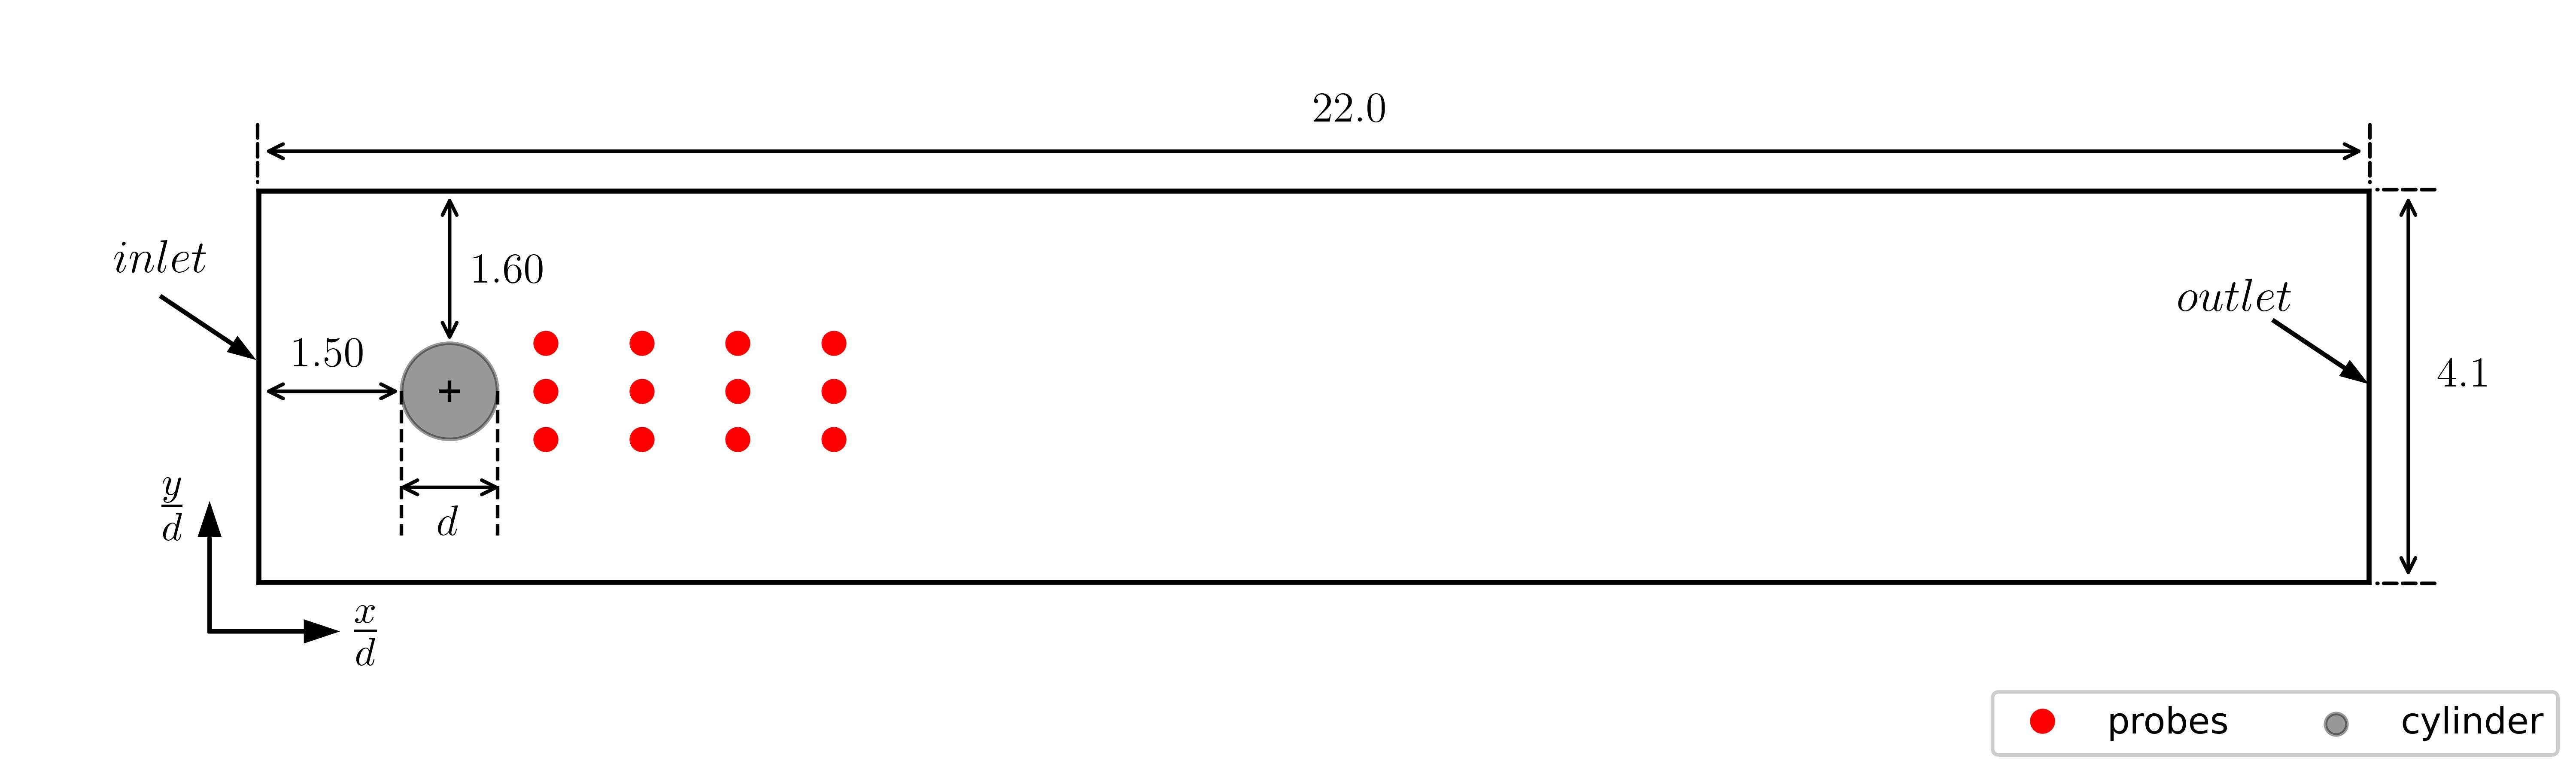

However, the number of probes can be altered in the *controlDict* within the *openfoam* directory of *drlfoam*. An example file containing additional $12$ probes in the vicinity of the cylinder can be found in the [controlDict_additional_probe_locations](https://github.com/JanisGeise/robust_MB_DRL_for_flow_control/blob/main/controlDict_additional_probe_locations) file.  

**Note:** in all the scripts, e.g. for post-processing, the pressure values at the probe locations are usually refered to as *states*, since these values are used at input into the policy network.

# 3. Choosing optimal parameters for a model-free training (MF-DRL) <a id="MF_training"></a>
When running a model-free training, there are mainly three parameters which control the outcome of the training. The first parameter is the buffer size, determining how many trajectories should be generated within each episode, this parameter is named *-b* in the *run_training.py* script. The second parameter is the length of the trajectory *-f*. It is important to note that the first $4s$ are uncontrolled (base case), therefore, the length of the trajectory (in the following *l* ) is always $l = f - 4s$ with $f$ denoting the parameter *f*  in the *run_training.py* script. Lastly, the number of episodes to run (parameter *-i* ) can be defined. The number of runners *-r* defines the number of parallel executions and should ideally be set equal to the buffer size (provided the hardware is not restricting the number of parallel processes). <br><br>
The setup for a model-free training is highly depending on the available resources. On a cluster like the [HPC](https://www.tu-braunschweig.de/it/dienste/21/phoenix) of TU Braunschweig, the buffer size is recommended to be set to $b=10$ and the trajectory length to $l=6s$ ($\equiv f=10$). The training should then converge after around $i = 80$ episodes and approximately $9$ hours. When running a training on a local machine, this setup is not feasible to run in a realisitc amount of time, however, a buffer size of $b=8$, trajectory length of $l=2s$ ($\equiv f=4$) can be run on an *Intel <sup>R</sup> Core<sup>TM</sup> i7-11800H* with $8$ cores in about *23h:19min* (also for $i = 80$ episodes and averaged over 3 different seeds). <br><br>
The following plots shall give an overview on how the performance is affected by the aforementioned parameters. To make the results independent of the available computational resources, all data are scaled to an interval of $[0, 1]$ using a min-max scaling. Consequently, changes within parameters are to be interpreted relative to each other. The reward function is defined as $r(c_d, c_l) = 3 - (c_d + 0.1 * | c_l |)$ with $r$ denoting the *reward* and therefore a measure of the performance of the agent over the course of the training. The computational costs on the other hand are taken into account by the required run time *t*.  In the following figures, $\mu$ refers to the mean values averaged over three different seeds and all episodes, while $\sigma$ denotes the corresponding standard deviation. All cases are run for $80$ episodes, ensuring the comparability when using the rewards averaged over all episodes.<br><br>
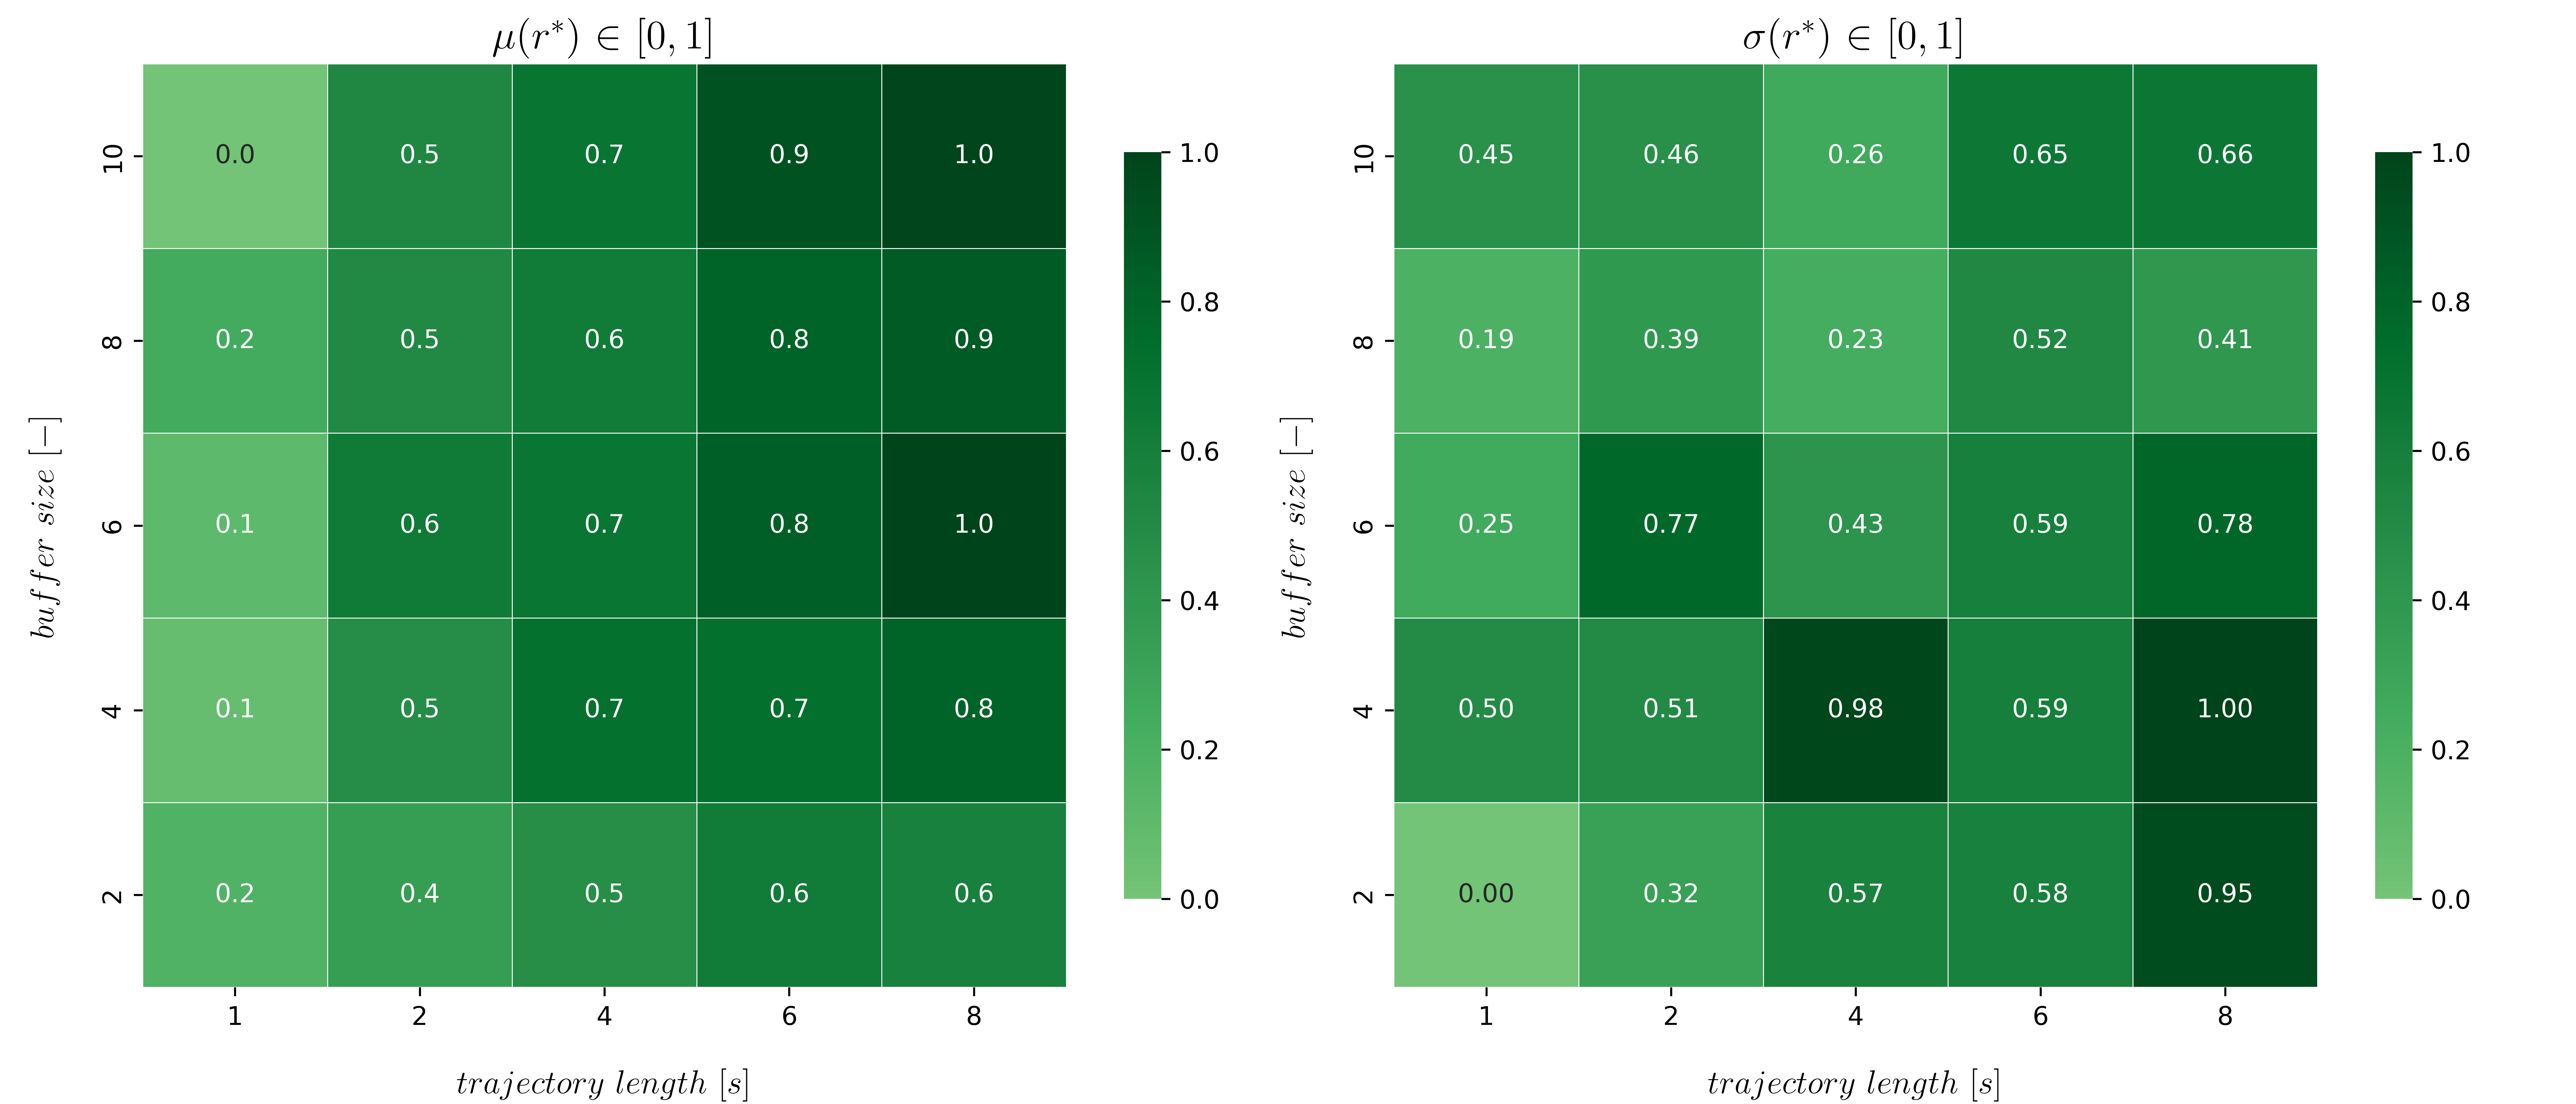
<br><br>
The buffer size has only little effect, as can be seen by the rewards. Therefore, it is recommended to reduce the buffer size in favour of an increased trajectory length if the computational resources are a limiting factor. The runtime, however, increases significantly when increasing the trajectory length from $l=6s$ to $l=8s$. Trajectory lengths of $l \ge 8s$ have no siginificant effect on the resulting performance leading mainly to an increase of the run times. Further, running a training for more than $80$ episodes may improve the results in some cases but in general the training should converge after $80$ episodes.<br><br>
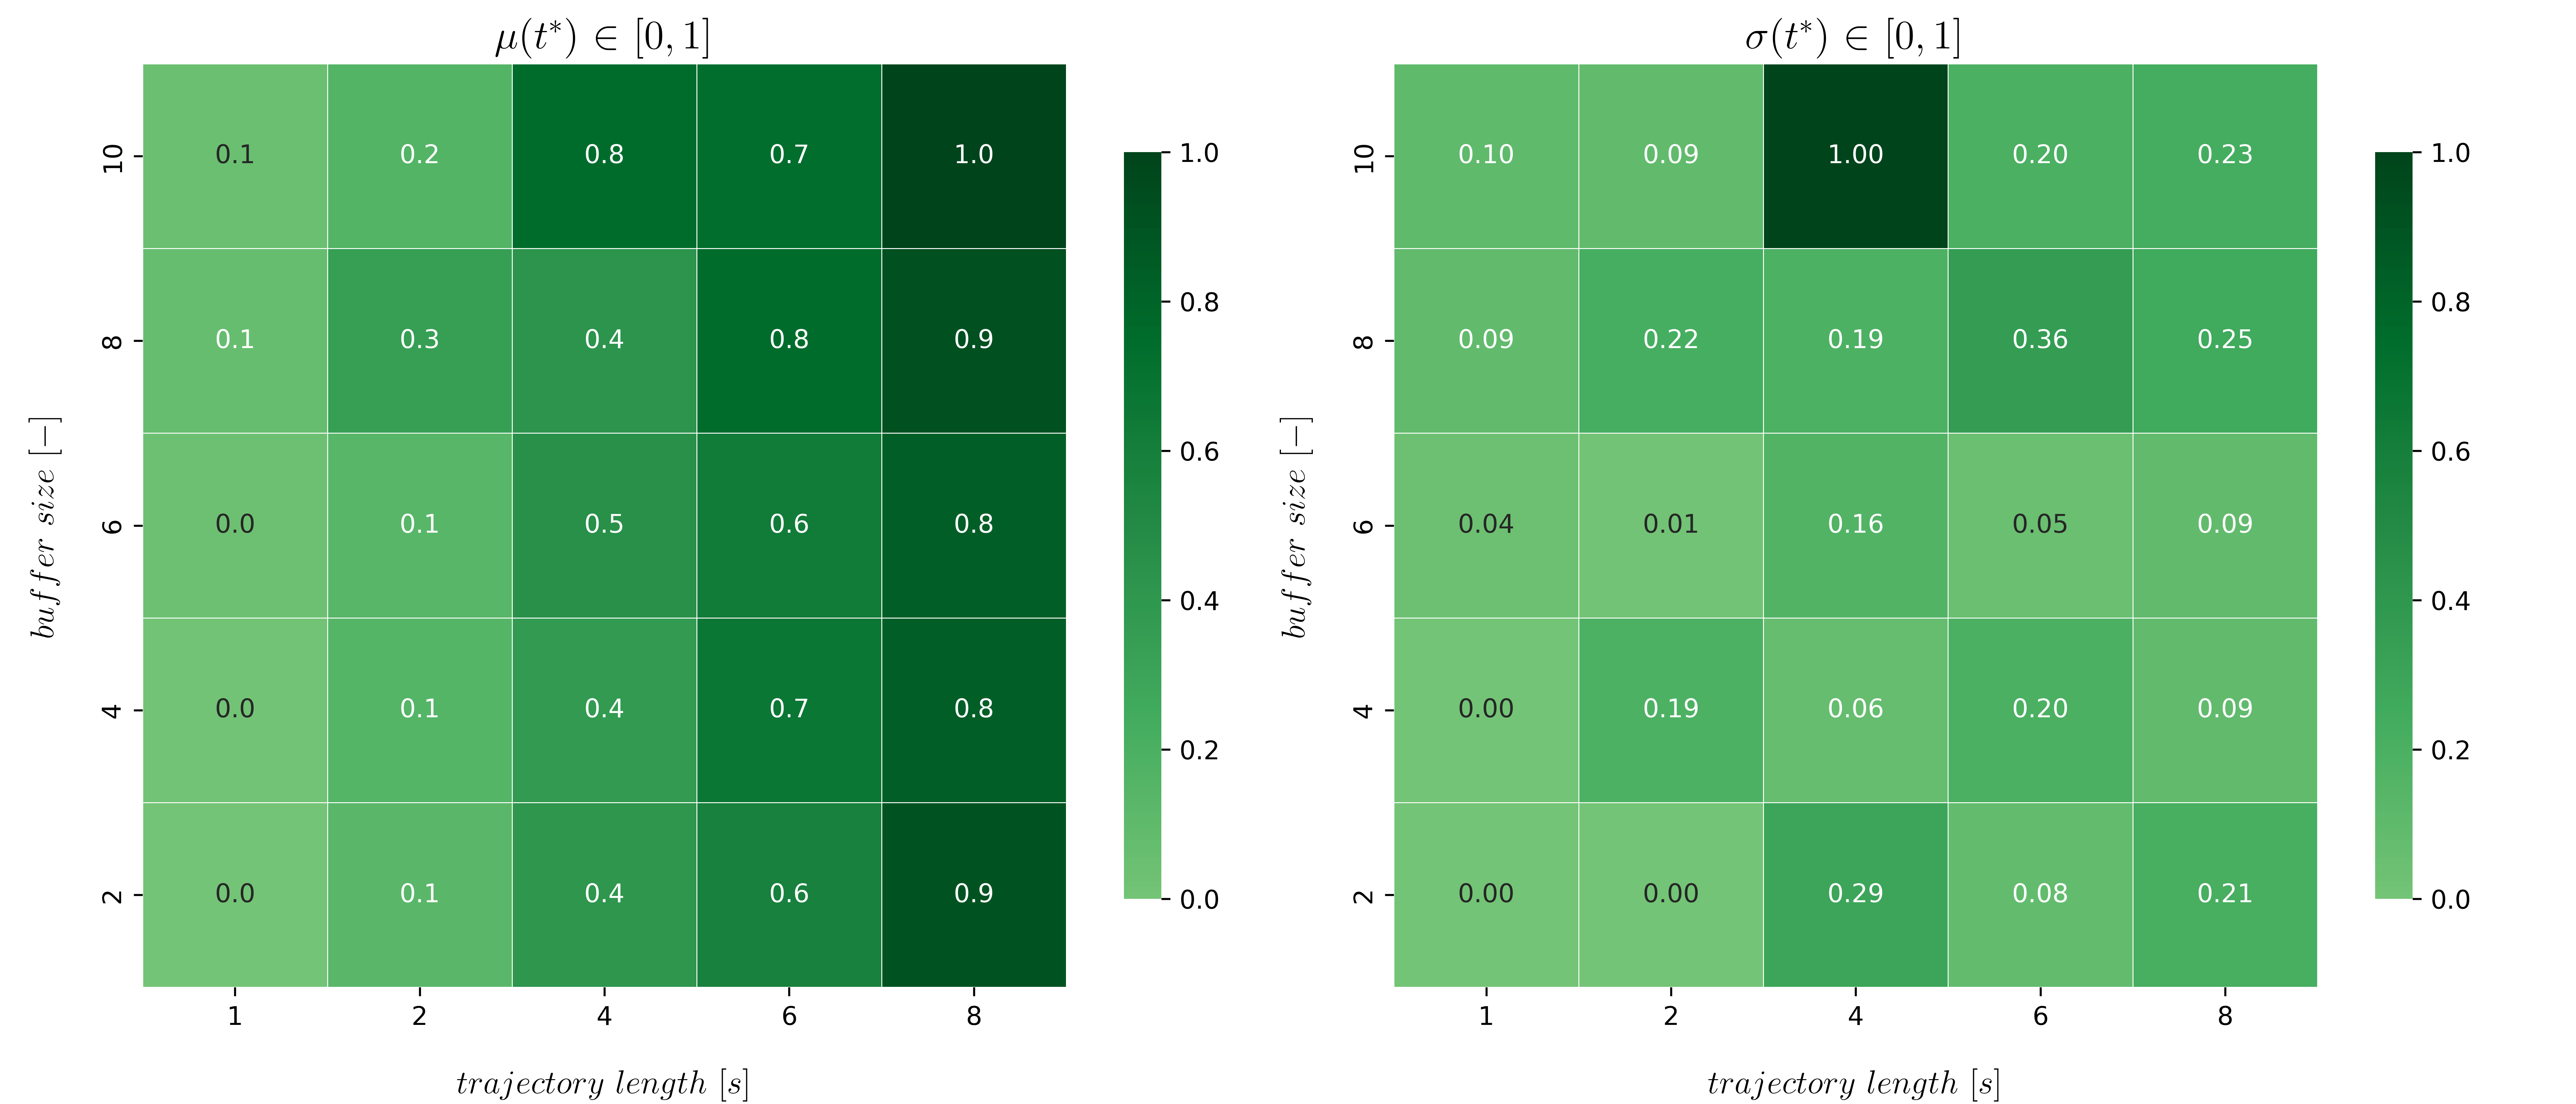

# 4. Performing a MB-training
The model-based trainings are generally conducted in the same way as the model-free trainings. The following list presents some important key facts regarding the training of the  environment models:  
- one model-ensemble is used for predicting $c_l$, $c_d$ and $p_i$. This means, each model in the ensemble gets the $c_d$, $c_l$, $p_i$ and $\omega$ values of the last $30$ subsequent time steps and then predicts the next time step  
- the model for making the predicition is randomly chosen out of the ensemble for each point of the trajectory, the implementation for predicting the trajectories is located in the *predict_trajectories* function of the *execute_prediction.py* script    
- the first $30$ points of the trajectory are taken from trajectories of the last two CFD episdoes in order to provide an intial input for the models from which they then can generate succsessively the remaining trajectory  
- each model is initialized with its own seed value prior the first training, in each new training the last state of the model is used as initialization in order to reduce the overall training time for the models
- each model in the ensemble has $3$ layers with $100$ neurons each, plus additional layers for batch normalization. The batch size is set to $25$ and can be altered in the *create_subset_of_data* function of the *env_model_rotating_cylinder.py* script
- for the model training, validation & sampling of the initial data (for predicting the trajectories using the environment models), only the current and the last CFD episode are used  
- the model-generated trajectories are always starting at t = 4s, which is the finish time of the base case (in contrast to the results presented in the report), this means that the qualitative course of the model-generated trajectories are the same as in the MF-episodes, so there is no discrepancy anymore between the avg. rewards of MF- and MB-episodes (the rewards now have a continuous, smooth course)
- the available data is split into $75\%$ training data and $25\%$ validation data, this splitting is done in the *generate_feature_labels* function of the *env_model_rotating_cylinder.py* script  
- inititally (episode $0$) each model is trained with max. $2500$ epochs, in each subsequent training, each model is trained with max. $1000$ epochs. These values can be altered in the *wrapper_train_env_model_ensemble* function of the *env_model_rotating_cylinder.py* script. Here exist two paramters, namely `e_re_train`, which denotes the max. nummber of epochs for training the models in all episodes $>0$ and the parameter `epochs` which denotes the max. number of epochs for the initial training of the models in episode zero. This parameter needs to be passed as argument into the `train_env_models' function if it should be modyfied  
- there exists an early stopping criteria to accelerate the model-training and in order to avoid overfitting, which is implemented as:
    - if the avg. validation loss (avg. over the last $50$ epochs) is $<$ 1e-6
    - or the avg. gradient of the validation loss (avg. over the last $50$ epochs) is $\ge$ -1e-7  
    
    then the training is aborted. This criteria is located in the *train_model* function in the *train_env_models.py* script  
- the available training and validation data is evenly split between all the models in the ensemble in order to maintain a constant duration for model training, independently of the number of models in the ensemble. Further, this increases the variance between the models annd therefore increases the overall prediction accuracy, since every model is trained on a different subset of the data. The splitting routine can be found in the *create_subset_of_data* function of the *env_model_rotating_cylinder.py* script  

- resources used for the benchmarks (HPC, AWS):
|  training   | resources      |
| :----:      |:-------------  |
| model-free  | $6$ CPUs for PPO training & main process <br> $2$ CPUs for each CFD simulation|
| model-based | 6 CPUs for PPO training & main process <br> $2$ CPUs for each CFD simulation <br> $10$ CPUs model training (each model), $10$ models in parallel <br> $10$ CPUs for each MB-trajectory, $10$ trajecories are generated in parallel|


The *SLURM* configurations can be adjusted according to the available resources in the *create_slurm_config* function of the *env_model_rotating_cylinder.py* script.

## 4.1 Alternation between MF- and MB-episodes 
**TODO**  
-> the switching criteria was adopted from [ME-TRPO](https://arxiv.org/abs/1802.10592)  
-> here a threshold of $50\%$ is used  
-> explain switching, were to find & how to change it  
-> how it is done if only 1 model used & why

# 5. Final results for trainings with $Re = 100$
The following plots illustrate the results of a MB-training in comparison to their MF counterpart and the performance of the final policies within the CFD environment at a Reynolds number of $Re = 100$. Some key facts about how these results were obtained:
 
- all cases have $r = b = 10$  
- the trajectory length in all cases $l = f - 4s$ where $f$ denotes the *finish* parameter for executing the training  
- all trainings were run for $200$ episodes each  
- the rewards and runtimes are averaged over $5$ different seeds. For the final policies, the best seed of each case was taken  
- the flow control starts in all cases at $t = 4s$  

the following table sums up the runtimes and resulting savings in runtime when using an MB-training instead of a MF one:


| $N_{models}$|<span style="font-weight:normal">avg. runtime</span> | $N_{episodes, CFD}$     | <span style="font-weight:normal">avg. decrease compared to MF \[\%\]</span>|
| :----:      |:-------------:                                      | :-----------------:     | :---------------------------------:|
| 1           |         h:min                                       | \[50, 50, 50, 50, 50 \] |                                    |
| 5           |         h:min                                       |                         |                                    |
| 10          |         h:min                                       |                         |                                    |

# 6. Concluding remarks and potential issues
The following list summarises all known issues and potential problems which may be encountered when runnning an model-based training using the current implemenation:

- **the model-generated trajectories are checked for invalid values, the boundaries in which a trajectory is seen as valid can be modified in the *check_trajectories* function of the *execute_prediction.py* script, since they depend various parameters such as on the Reynolds number and the environment**. An indicator of unfavorable chosen boundaries is the discard of model-generated trajectories or if the PPO-training is constantly switching back to CFD after $50$ trials of generating trajectories. In general the number of discarded trajectories in an MB-episode should be somewhere around $N_{discards} = 1...2$ for a buffer size of $b=10$. In the complete PPO-training the total amount of discarded trajectories is usually $N_{discards} < 10...15$ for a PPO-training with $80$ episodes and a buffer size of $10$. These discarded trajectories appear normally in the first third of the PPO-training as a consequence of inaccurate environment models. An example of well-working boundaries for $Re = 100$ and $Re = 500$ can be found in the report along with their derivation.  
- the *SLURM* configs are implemented for the [Phoenix](https://www.tu-braunschweig.de/en/it/dienste/21/phoenix) cluster of TU Braunschweig as well as for AWS. Especially when running on AWS, the name of the partition and constraints may differ, as well as the available resources. These parameters can be adjusted in the *create_slurm_config* function of the *env_model_rotating_cylinder.py* script as mentioned before.
- for trainings on an HPC cluster: in case $N_{models} > 10$ or `buffer_size < 10`, the number of runners can be increased, the default value is set to `n_runners_max=10`. This means:  
    - for model training $n_{runner}$ models are trained in parallel. This value can be adjusted in the *wrapper_train_env_model_ensemble* function of the *env_model_rotating_cylinder.py* script  
    (line `manager = TaskManager(n_runners_max=10)`)  
    - for predicting the trajetories using the environment models, $n_{runner}$ trajectories are predicted in parallel. The number of runners can here be adjusted in the *fill_buffer_from_models* function in the *predict_trajectories.py* script (line `manager = TaskManager(n_runners_max=10)`)  
- the training as well as the prediction of the trajectories by the environment models is done on CPUs, because by the time the here presented results were created there were not enough resources for GPU training and prediction available. However, if there are enough resources for GPU training available, it is sufficient to just install `torch` with *CUDA*, currently for the `torch` version 1.12.1 as:  

    `$ pip uninstall torch`  
    `$ pip install torch==1.12.1+cu116 torchvision==0.13.1+cu116 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu116`  
    
    and adjustment of name of the partition for the *SLURM* configration, in case the training is conducted on a HPC cluster. For running the training on a local machine, no further adjustments are necessary.
- the number of environment models in the ensemble can be passed into the constructor of the *SetupEnvironmentModel* class in the *run_training* script, e.g. as 

    `env_model = SetupEnvironmentModel(path=training_path, n_models=10)`  
    
    However, for $N_{models} > 10$, the performance in terms of rewards will decrease significantly. This is caused by the implementation for splitting the available training data. As described, all available training data is evenly split between the models, when increasing the number of models, the absolute amount of training data for each model decreases. At some point (if $N_{models}$ is high), the amount of training data for each models is not sufficient anymore to obtain accurate predictions by the environment models. The reason for choosing this kind of implementation is, that the required training time is then more or less independent of the number of models, since the data is evenly split up between all models. It was found that $N_{models} = 5$ yields generally the best results.